In [69]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
import numpy as np
import json

import librosa
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers

import matplotlib.pyplot as plt

In [71]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/mfcc15_data_audiomentations.json'

In [72]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [73]:
X = np.array(data["mfcc"])
y = np.array(data["label"])

In [74]:
print(X.shape)
print(y.shape)

(1280, 302, 15)
(1280,)


In [75]:
X=X.reshape(X.shape[0],-1,15,1)

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [77]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1024, 302, 15, 1)
(1024,)
(256, 302, 15, 1)
(256,)


In [78]:
model=Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(302,15,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=3e-4, l2=3e-3),bias_regularizer=regularizers.l2(3e-3),activity_regularizer=regularizers.l2(3e-4)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),bias_regularizer=regularizers.l2(1e-2),activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 300, 13, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 6, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 5, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 149, 5, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 23840)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6103296   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [80]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [81]:
print(X.shape)
print(y.shape)

(1280, 302, 15, 1)
(1280,)


In [82]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for train, test in kfold.split(X, y):
  print(type(X[train]))
  print(X[train].shape)
  print(type(y[test]))
  print(y[test].shape)

<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)
<class 'numpy.ndarray'>
(1024, 302, 15, 1)
<class 'numpy.ndarray'>
(256,)


In [83]:
fold_dict={}
fold_dict['y_test']=y[test]

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

pred_folds_list=[]

cvscores = []
for train, test in kfold.split(X, y):
  
  fold_dict=dict()
  model.fit(X[train], y[train], epochs=200, batch_size=32, verbose=0)
  # evaluate the model
  scores = model.evaluate(X[test], y[test], verbose=0)
  fold_dict['y_test']=y[test]
  fold_dict['y_pred']=model.predict(X[test])
  pred_folds_list.append(fold_dict)
  
  y_Pred=model.predict(X[test])
  auc = roc_auc_score(y[test], y_Pred)
  print('AUC: %.3f' % auc)
    
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  print("\n")

  cvscores.append(scores[1] * 100)
 


AUC: 0.922
accuracy: 89.84%


AUC: 0.979
accuracy: 93.75%


AUC: 0.987
accuracy: 96.09%


AUC: 0.988
accuracy: 96.48%


AUC: 0.992
accuracy: 96.88%




In [85]:

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

94.61% (+/- 2.62%)


 history = model.fit(X, y, batch_size=32, epochs=150)

In [86]:
#model.save(r'/content/gdrive/MyDrive/COVID_cough/models/FULLcnn_mfcc15audiomentations.h5',save_format='h5')

In [87]:
from keras.models import load_model

model=load_model('/content/gdrive/MyDrive/COVID_cough/models/FULLcnn_mfcc15audiomentations.h5')

In [88]:
y_pred=model.predict(X_test)

In [89]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

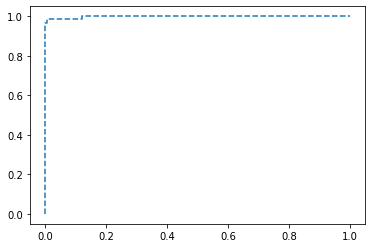

In [90]:
sum_tests=0
sum_preds=0

for idx,item in enumerate(pred_folds_list):
  sum_tests+=item['y_test']
  sum_preds+=item['y_pred']

avg_tests=sum_tests/len(pred_folds_list)
avg_preds=sum_preds/len(pred_folds_list)

fpr, tpr, thresholds = roc_curve(avg_tests, avg_preds)
plt.plot(fpr, tpr, linestyle='--')

[[175  18]
 [ 11  52]]

[[192   1]
 [ 10  53]]

[[193   0]
 [ 10  53]]

[[192   1]
 [  8  55]]

[[193   0]
 [  8  55]]



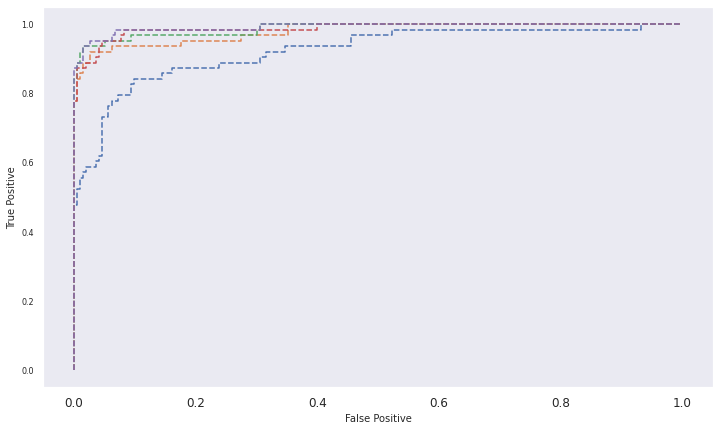

In [164]:
plt.figure(figsize=(12,7))


for idx,item in enumerate(pred_folds_list):
  
  fpr, tpr, thresholds = roc_curve(item['y_test'], item['y_pred'])

  for i in range(0,len(tpr)):
    if tpr[i]>=0.8:
      thresh=thresholds[i]
      
      y_pred_x=[]
      for i in item['y_pred']:
        if i>=thresh:
          y_pred_x.append(1)
        else:
          y_pred_x.append(0)

      cm=confusion_matrix(item['y_test'],y_pred_x)
      print(cm)
      print()
      break

  plt.plot(fpr, tpr, linestyle='--')



  
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.grid()
plt.savefig('fold_rocpplots.pdf', dpi=500)
plt.show()



In [137]:
cm

array([[193,   0],
       [  8,  55]])

In [153]:
final_cm=np.array([[185,8],
                   [10,53]])

In [141]:
df_cm

,0,1
0,185,8
1,10,53


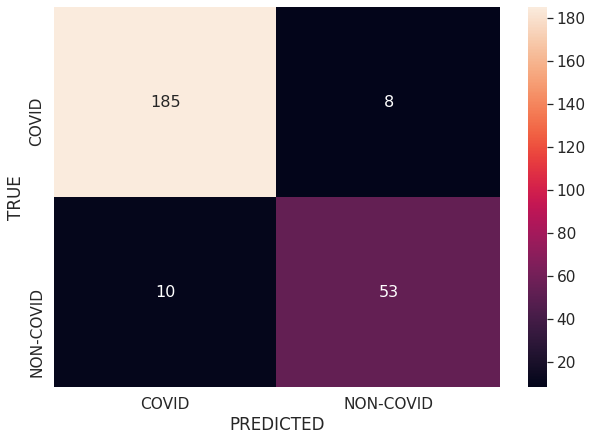

In [182]:
df_cm = pd.DataFrame(final_cm, index = [i for i in ['COVID','NON-COVID']],
                     columns = [i for i in ['COVID','NON-COVID']]
                     )
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.3g') # font size

plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.savefig('confusion_matrix.pdf', dpi=577)

plt.show()

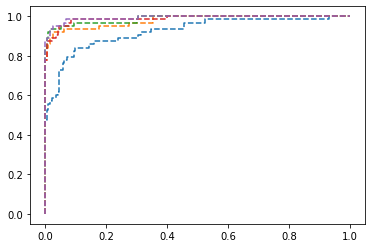

In [92]:
fpr_list=[]
tpr_list=[]

for idx,item in enumerate(pred_folds_list):
  
  fpr, tpr, thresholds = roc_curve(item['y_test'], item['y_pred'])
  fpr_list.append(fpr)
  tpr_list.append(tpr)

  plt.plot(fpr, tpr, linestyle='--')



  

plt.show()
#plt.savefig('average rocpplots.png', dpi=500)

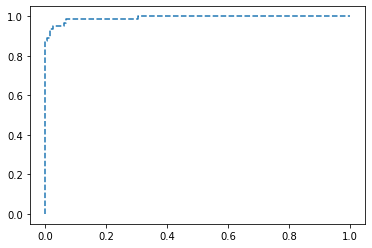

In [93]:
plt.plot(fpr, tpr, linestyle='--')

In [94]:


auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 1.000


In [95]:
#model.save('cnn_auc888.h5',save_format='h5')

In [96]:
#Lmodel=load_model('cnn_auc888.h5')

In [97]:
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [98]:
y_preds=[]

for i in y_pred:
  if i >=0.4:
    y_preds.append(1)
  else:
    y_preds.append(0)

y_preds=np.array(y_preds)

In [99]:
y_preds

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [100]:
confusion_matrix(y_test, y_preds)

array([[193,   0],
       [  0,  63]])

In [101]:
model.save('/content/gdrive/MyDrive/COVID_cough/models/mfcc15audiomentations.h5',save_format='h5')

Blind set eval

In [102]:
import pandas as pd

In [103]:
from keras.models import load_model

model=load_model(r'/content/gdrive/MyDrive/COVID_cough/models/mfcc15audiomentations.h5')

In [104]:
df=pd.read_csv('/content/gdrive/MyDrive/COVID_cough/test_metadata.csv')

In [105]:
df

,File_name,Covid_status,Gender,Nationality
0,ehmkjtFk_cough,?,m,O
1,UCxrHdoP_cough,?,m,I
2,afJveyWf_cough,?,f,I
3,ckgXCsSh_cough,?,m,I
4,KprOlhNx_cough,?,m,I
...,...,...,...,...
228,WxtUSymX_cough,?,f,I
229,VYFvgWMm_cough,?,f,I
230,coWKLPUF_cough,?,f,I
231,XvOqdxQJ_cough,?,m,I


In [106]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/Evaluations/mfcc15_blind_set.json'

In [107]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [108]:
X = np.array(data["mfcc"])
X=X.reshape(X.shape[0],-1,15,1)
X.shape

(233, 302, 15, 1)

In [109]:
y_pred_probs=model.predict(X)

In [110]:
y=list(y_pred_probs.reshape(-1))

In [111]:
dicto={'File_name':list(df['File_name']),'Probability':y}

In [112]:
results=pd.DataFrame(dicto)

In [113]:
results.to_csv('15mfcc_audiomentation_Blind_Set_results.csv',index=False)

In [114]:
x=pd.read_csv('15mfcc_audiomentation_Blind_Set_results.csv')

In [115]:
type(x['Probability'][0])

numpy.float64

Val Folds eval

In [116]:
df=pd.read_csv('/content/gdrive/MyDrive/COVID_cough/Val_set.csv')

In [117]:
df

,file_name
0,PQFgfbUS_cough
1,dpITIaDY_cough
2,IzXaepIB_cough
3,ZVKSsFiW_cough
4,LFqjhpiv_cough
...,...
1085,tWjZnGra_cough
1086,dAlFPhsp_cough
1087,gjLXOetR_cough
1088,WJAIhgpc_cough


In [118]:
data_path = '/content/gdrive/MyDrive/COVID_cough/data/Evaluations/mfcc15_val_folds.json'

In [119]:
with open(data_path, "r") as fp:
        data = json.load(fp)
        

In [120]:
X = np.array(data["mfcc"])
X=X.reshape(X.shape[0],-1,15,1)
X.shape

(1090, 302, 15, 1)

In [121]:
y_pred_probs=model.predict(X)

In [122]:
y=list(y_pred_probs.reshape(-1))

In [123]:
dicto={'File_name':list(df['file_name']),'Probability':y}

In [124]:
results=pd.DataFrame(dicto)

In [125]:
results.to_csv('15mfcc_audiomentations_val_set_results.csv',index=False)

In [126]:
x=pd.read_csv('15mfcc_audiomentations_val_set_results.csv')

In [127]:
type(x['Probability'][0])

numpy.float64